In [1]:
from feature_utils.parallel import BufferedSOAPFeatures, get_features_in_parallel, get_optimal_radial_basis_hypers_parallel
from loader.loader import load_data
from copy import deepcopy
import numpy as np
from sklearn.linear_model import RidgeCV
from rascal.representations import SphericalInvariants as SOAP
from rascal.utils import get_optimal_radial_basis_hypers
from rascal.neighbourlist.structure_manager import mask_center_atoms_by_id
from skcosmo.model_selection import atom_groups_by_frame
from sklearn.linear_model import LinearRegression, Ridge
from copy import deepcopy
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import time
from sklearn.compose import TransformedTargetRegressor
from skcosmo.preprocessing import StandardFlexibleScaler
#from sklearnex import patch_sklearn
#patch_sklearn()

from sklearn.svm import LinearSVR
from sklearn.base import clone
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import PairwiseKernel

In [2]:
from skcosmo.preprocessing import StandardFlexibleScaler

In [3]:
train_structures, test_structures, train_properties, test_properties = load_data("./make_tensor_data/train_tensor/CSD-3k+S546_shift_tensors.xyz",\
                                                                                    "./make_tensor_data/test_tensor/CSD-500+104-7_shift_tensors.xyz",selected_species=7, random_subsample_train=200,random_subsample_test=200)

In [4]:
from sklearn.metrics.pairwise import polynomial_kernel

In [12]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=4.5,
              max_radial=8,
              max_angular=8,
              gaussian_sigma_constant=0.3,
              gaussian_sigma_type="Constant",
              radial_basis="GTO",
              normalize=True,
              cutoff_smooth_width=0.3,
              cutoff_function_type="RadialScaling",
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              cutoff_function_parameters= dict(rate=1,
                    scale=2.0,
                    exponent=3
                        ),
              compute_gradients=False,
              expansion_by_species_method="user defined",
              global_species=[1, 6, 7, 8, 16]
              )

hypers = get_optimal_radial_basis_hypers_parallel(hypers,train_structures)

nested_param = dict(rate=1,
                    scale=3.0,
                    exponent=6
                        )

kernel_params = dict()

"""space = [Real(10**-5, 10**2, "log-uniform", name='alpha'),
        Real(0.05,1.5, "uniform", name="gaussian_sigma_constant"),
        Real(2.,4.5, "uniform", name="interaction_cutoff")]"""

space = [Real(10**-6, 10**1, "log-uniform", name='alpha'),
        #Real(1.,3.5, "uniform", name="scale"),
        Real(3.5,8.0, "uniform", name="interaction_cutoff"),
        Real(0.01,0.5, "uniform", name="gaussian_sigma_constant"),
        #Real(1.,5., "uniform", name="exponent"),
        #Real(0.5,3., "uniform", name="rate")
        ]

reg = Ridge()
#TransformedTargetRegressor(regressor=LinearSVR(loss="squared_epsilon_insensitive"), transformer=StandardFlexibleScaler(),check_inverse=False)
y = train_properties
atom_groups = atom_groups_by_frame(train_structures)
Feature_gen = BufferedSOAPFeatures(train_structures, hypers,optimize=False,n_cores=-1)




@use_named_args(space)
def soap_objective(**params):
    update_dict = {}
    
    new_params = params.copy()
    #nested_dict_param = deepcopy(Feature_gen.calculator_params)
    #nested_dict_param = nested_dict_param["cutoff_function_parameters"]
    
    for key, value in new_params.items():
        if key in Feature_gen.calculator_params:
            #hypers[key] = value
            update_dict[key] = params.pop(key, None)
        """if key in nested_param:
            nested_dict_param[key] = params.pop(key, None)
            #print("I update my {} to {}".format(key,value))
        
        update_dict["cutoff_function_parameters"] = nested_dict_param"""
            
            
    #print(update_dict)
    start_time = time.time()
    
    
    
    X = Feature_gen.get_features(update_dict)
    print("--- feature_gen time %s seconds ---" % (time.time() - start_time))
    #print(X.shape)
    
    start_time = time.time()
    Kernel = polynomial_kernel(X)
    #print(Feature_gen.hypers["max_angular"])
    start_time = time.time()
    splits = list(GroupKFold(n_splits=3).split(Kernel,y,groups=atom_groups))
    
    score = [] 
    
    reg.set_params({"alpha":params.pop("alpha",None)})
    
    
    
    Kernel = 
    
    
    for trainsplit, testsplit in GroupKFold(n_splits=5).split(X,y,groups=atom_groups):
        X_train = X[trainsplit]
        X_test = X[testsplit]

        
        y_train = y[trainsplit].reshape(-1, 1)
        #print(y_train)
        y_test = y[testsplit].reshape(-1, 1)

        scaler_X = StandardFlexibleScaler().fit(X_train)
        X_train = scaler_X.transform(X_train,copy=True)
        X_test = scaler_X.transform(X_test,copy=True)

        scaler_y = StandardFlexibleScaler().fit(y_train)
        y_train = scaler_y.transform(y_train,copy=True)
        y_test = scaler_y.transform(y_test,copy=True)

        reg.fit(X_train,y_train)

        y_test_pred = reg.predict(X_test)

        score.append(mean_squared_error(scaler_y.inverse_transform(y_test), scaler_y.inverse_transform(y_test_pred)))
        
    #print(reg.alpha)
    
    #score = -np.mean(cross_val_score(reg, X, y, cv=splits, n_jobs=1,
    #                                scoring="neg_mean_squared_error"))
    
    print("--- cross_val time %s seconds ---" % (time.time() - start_time))
    #print(score)    
    return -np.mean(score)

In [13]:
## patch_sklearn()
import time
start_time = time.time()
res_gp = gp_minimize(soap_objective, space, n_calls=25, random_state=0, n_jobs=1)
print("--- 10 steps took %s seconds ---" % (time.time() - start_time))

--- feature_gen time 0.895482063293457 seconds ---
--- cross_val time 2.0453360080718994 seconds ---
--- feature_gen time 0.7276520729064941 seconds ---
--- cross_val time 2.035644769668579 seconds ---
--- feature_gen time 0.5316658020019531 seconds ---
--- cross_val time 2.1040663719177246 seconds ---
--- feature_gen time 0.8227658271789551 seconds ---
--- cross_val time 2.0389199256896973 seconds ---
--- feature_gen time 0.7466583251953125 seconds ---
--- cross_val time 2.0485167503356934 seconds ---
--- feature_gen time 0.699904203414917 seconds ---
--- cross_val time 2.0785837173461914 seconds ---
--- feature_gen time 0.8600943088531494 seconds ---
--- cross_val time 2.07301926612854 seconds ---
--- feature_gen time 0.7131829261779785 seconds ---
--- cross_val time 2.158924102783203 seconds ---
--- feature_gen time 0.76963210105896 seconds ---
--- cross_val time 2.083653211593628 seconds ---
--- feature_gen time 0.5935907363891602 seconds ---
--- cross_val time 2.0612800121307373 s

/ssd/scratch/kellner/miniconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--- cross_val time 2.0700504779815674 seconds ---
--- feature_gen time 5.4836273193359375e-06 seconds ---
--- cross_val time 2.074106454849243 seconds ---
--- feature_gen time 0.8647043704986572 seconds ---
--- cross_val time 2.0458717346191406 seconds ---
--- feature_gen time 1.078277587890625 seconds ---
--- cross_val time 2.040588617324829 seconds ---


/ssd/scratch/kellner/miniconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--- feature_gen time 0.8302633762359619 seconds ---
--- cross_val time 2.060558795928955 seconds ---
--- feature_gen time 6.198883056640625e-06 seconds ---


/ssd/scratch/kellner/miniconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--- cross_val time 2.0540952682495117 seconds ---
--- feature_gen time 5.4836273193359375e-06 seconds ---


/ssd/scratch/kellner/miniconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--- cross_val time 2.0364983081817627 seconds ---
--- feature_gen time 1.0231359004974365 seconds ---
--- cross_val time 2.0161566734313965 seconds ---
--- feature_gen time 5.7220458984375e-06 seconds ---


/ssd/scratch/kellner/miniconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--- cross_val time 2.0232717990875244 seconds ---
--- feature_gen time 0.937593936920166 seconds ---
--- cross_val time 2.043954372406006 seconds ---
--- feature_gen time 1.0136868953704834 seconds ---
--- cross_val time 2.040130853652954 seconds ---
--- feature_gen time 5.245208740234375e-06 seconds ---
--- cross_val time 2.035952091217041 seconds ---
--- feature_gen time 5.4836273193359375e-06 seconds ---
--- cross_val time 2.0428946018218994 seconds ---
--- 10 steps took 78.18302321434021 seconds ---


In [ ]:
res

In [33]:
res_gp.x

[2.4491024634012133, 6.306036635536876, 0.19834703657342298]

In [30]:

for trainsplit, testsplit in GroupKFold(n_splits=5).split(y,groups=atom_groups):
    print(trainsplit)

[   0    1    2 ... 2558 2559 2560]
[  16   17   18 ... 2550 2551 2552]
[   0    1    2 ... 2558 2559 2560]
[   0    1    2 ... 2558 2559 2560]
[   0    1    2 ... 2558 2559 2560]


In [20]:
print(train_properties)

[ 74.52  74.52  74.51 ... 108.16 108.12 108.16]


In [18]:
help(StandardFlexibleScaler)

Help on class StandardFlexibleScaler in module skcosmo.preprocessing._data:

class StandardFlexibleScaler(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator)
 |  StandardFlexibleScaler(with_mean=True, with_std=True, column_wise=False, rtol=0, atol=1e-12, copy=False)
 |  
 |  Standardize features by removing the mean and scaling to unit variance.
 |  Reduce the mean of the column to zero and, in the case of `column_wise=True`
 |  the variance of each column equal to one / number of columns.
 |  The standard score of a sample `x` is calculated as:
 |  
 |      z = (x - u) / s
 |  
 |  where `u` is the mean of the samples if `with_mean`, otherwise zero,
 |  and `s` is the standard deviation of the samples if `with_std` or one.
 |  
 |  Centering and scaling can occur independently for each feature by calculating
 |  the appropriate statistics for the input or for the
 |  whole matrix (`column_wise=False`). The mean and standard deviation are then
 |  stored for use on later data us

In [35]:
Xtrain = get_features_in_parallel(train_structures,SOAP,hypers)

In [61]:
mymodel = TransformedTargetRegressor(regressor=RidgeCV(),transformer=StandardFlexibleScaler())

In [62]:
mymodel.fit(Xtrain,train_properties)

KeyboardInterrupt: 

In [58]:
cross_val_score(mymodel,Xtrain,train_properties,groups=group,cv=GroupKFold(),scoring="neg_mean_squared_error")

array([-1236.21587596, -1267.61661554, -1108.24118909, -1254.04773058,
       -1036.6450259 ])

In [60]:
cross_val_score(mymodel,Xtrain,train_properties,groups=group,cv=GroupKFold(),scoring="neg_mean_squared_error")

KeyboardInterrupt: 

In [27]:
mymodel.get_params()

{'check_inverse': True,
 'func': None,
 'inverse_func': None,
 'regressor__alpha': 1.0,
 'regressor__copy_X': True,
 'regressor__fit_intercept': True,
 'regressor__max_iter': None,
 'regressor__normalize': 'deprecated',
 'regressor__positive': False,
 'regressor__random_state': None,
 'regressor__solver': 'auto',
 'regressor__tol': 0.001,
 'regressor': Ridge(),
 'transformer__atol': 1e-12,
 'transformer__column_wise': False,
 'transformer__copy': False,
 'transformer__rtol': 0,
 'transformer__with_mean': True,
 'transformer__with_std': True,
 'transformer': StandardFlexibleScaler()}

In [25]:
from sklearn.model_selection import GridSearchCV

In [42]:
params = {"regressor__alpha":np.logspace(-6,1,num=14)}

In [45]:
from sklearn.model_selection import LeaveOneGroupOut

In [46]:
group = atom_groups_by_frame(train_structures)

In [54]:
cf = GridSearchCV(estimator = mymodel, cv=LeaveOneGroupOut(), param_grid=params,scoring="neg_mean_squared_error",n_jobs=8)

In [55]:
cf.fit(Xtrain,train_properties,groups=group,verbose=1)

KeyboardInterrupt: 

In [23]:
mymodel.fit(Xtrain,train_properties)

RidgeCV(alphas=array([1.00000000e-12, 2.59294380e-12, 6.72335754e-12, 1.74332882e-11,
       4.52035366e-11, 1.17210230e-10, 3.03919538e-10, 7.88046282e-10,
       2.04335972e-09, 5.29831691e-09, 1.37382380e-08, 3.56224789e-08,
       9.23670857e-08, 2.39502662e-07, 6.21016942e-07, 1.61026203e-06,
       4.17531894e-06, 1.08263673e-05, 2.80721620e-05, 7.27895384e-05,
       1.88739182e-04, 4.89390092e-04, 1.26896100e-03, 3.29034456e-03,
       8.53167852e-03, 2.21221629e-02, 5.73615251e-02, 1.48735211e-01,
       3.85662042e-01, 1.00000000e+00]))

In [13]:
scaler = StandardFlexibleScaler()
Xtrain = scaler.fit_transform(Xtrain)


In [9]:
from sklearn.linear_model import RidgeCV

In [13]:
mymodel.regressor.alpha_

AttributeError: 'RidgeCV' object has no attribute 'alpha_'

In [24]:
mymodel.alpha_

2.0433597178569395e-09

In [16]:
Xtrain

array([[ 6.16310782e-04,  5.11436180e-03,  3.34222425e-03, ...,
        -8.60169604e-06, -7.58355178e-06, -7.53181984e-06],
       [ 6.16477006e-04,  5.11455509e-03,  3.34234429e-03, ...,
        -8.60169604e-06, -7.58355178e-06, -7.53181984e-06],
       [ 6.16475958e-04,  5.11455417e-03,  3.34234370e-03, ...,
        -8.60169604e-06, -7.58355178e-06, -7.53181984e-06],
       ...,
       [-5.60464454e-03, -2.53845618e-03, -2.08982179e-03, ...,
         1.55152148e-06,  3.69392899e-06,  1.96776767e-06],
       [-5.60464433e-03, -2.53845462e-03, -2.08982050e-03, ...,
         1.55038414e-06,  3.69318095e-06,  1.96783563e-06],
       [-5.60464456e-03, -2.53845624e-03, -2.08982183e-03, ...,
         1.55159646e-06,  3.69397016e-06,  1.96774082e-06]])

In [15]:
kern

array([[5.10182591e+00, 1.23572831e+00, 1.12229594e+00, ...,
        1.03295614e-03, 1.02890147e-03, 1.04653595e-03],
       [1.23572831e+00, 6.46453173e-01, 5.30582521e-01, ...,
        2.91924627e-04, 2.70881238e-04, 2.68104709e-04],
       [1.12229594e+00, 5.30582521e-01, 4.77451549e-01, ...,
        2.70024085e-04, 2.50268807e-04, 2.55010167e-04],
       ...,
       [1.03295614e-03, 2.91924627e-04, 2.70024085e-04, ...,
        6.01780035e-05, 4.19107534e-05, 4.33046231e-05],
       [1.02890147e-03, 2.70881238e-04, 2.50268807e-04, ...,
        4.19107534e-05, 3.88819385e-05, 3.50572202e-05],
       [1.04653595e-03, 2.68104709e-04, 2.55010167e-04, ...,
        4.33046231e-05, 3.50572202e-05, 3.96132709e-05]])

In [20]:
A = np.arange(81)
A = A.reshape((9,9))
A[np.ix_(np.array([1,2,3]),np.array([1,2,3]))]


array([[10, 11, 12],
       [19, 20, 21],
       [28, 29, 30]])

In [10]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=4.5,
              max_radial=8,
              max_angular=8,
              gaussian_sigma_constant=0.3,
              gaussian_sigma_type="Constant",
              radial_basis="GTO",
              normalize=True,
              cutoff_smooth_width=0.3,
              cutoff_function_type="RadialScaling",
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              cutoff_function_parameters= dict(rate=1,
                    scale=5.0,
                    exponent=3.1
                        ),
              compute_gradients=False,
              expansion_by_species_method="user defined",
              global_species=[1, 6, 7, 8, 16]
              )
start_time = time.time()
get_features_in_parallel(train_structures,SOAP,hypers,n_cores=8)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.7550456523895264 seconds ---


In [5]:
calc_object = BufferedSOAPFeatures(train_structures,hypers,optimize=False,n_cores=8)
start_time = time.time()
X = calc_object.get_features({})
print("--- %s seconds ---" % (time.time() - start_time))

--- 8.665013313293457 seconds ---


In [6]:
X.shape

(134692, 8640)

In [7]:
start_time = time.time()
get_optimal_radial_basis_hypers_parallel(hypers,train_structures)
print("--- %s seconds ---" % (time.time() - start_time))

--- 16.396571397781372 seconds ---


In [3]:
help(GroupKFold)

Help on class GroupKFold in module sklearn.model_selection._split:

class GroupKFold(_BaseKFold)
 |  GroupKFold(n_splits=5)
 |  
 |  K-fold iterator variant with non-overlapping groups.
 |  
 |  The same group will not appear in two different folds (the number of
 |  distinct groups has to be at least equal to the number of folds).
 |  
 |  The folds are approximately balanced in the sense that the number of
 |  distinct groups is approximately the same in each fold.
 |  
 |  Read more in the :ref:`User Guide <group_k_fold>`.
 |  
 |  Parameters
 |  ----------
 |  n_splits : int, default=5
 |      Number of folds. Must be at least 2.
 |  
 |      .. versionchanged:: 0.22
 |          ``n_splits`` default value changed from 3 to 5.
 |  
 |  Examples
 |  --------
 |  >>> import numpy as np
 |  >>> from sklearn.model_selection import GroupKFold
 |  >>> X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
 |  >>> y = np.array([1, 2, 3, 4])
 |  >>> groups = np.array([0, 0, 2, 2])
 |  >>> group_kfo

In [24]:
reg.get_params()

{'check_inverse': False,
 'func': None,
 'inverse_func': None,
 'regressor__C': 1.0,
 'regressor__dual': True,
 'regressor__epsilon': 0.0,
 'regressor__fit_intercept': True,
 'regressor__intercept_scaling': 1.0,
 'regressor__loss': 'epsilon_insensitive',
 'regressor__max_iter': 1000,
 'regressor__random_state': None,
 'regressor__tol': 0.0001,
 'regressor__verbose': 0,
 'regressor': LinearSVR(),
 'transformer__atol': 1e-12,
 'transformer__column_wise': False,
 'transformer__copy': False,
 'transformer__rtol': 0,
 'transformer__with_mean': True,
 'transformer__with_std': True,
 'transformer': StandardFlexibleScaler()}

In [14]:
class MyFlex(StandardFlexibleScaler):
    def _validate_data(
        self,
        X="no_validation",
        y="no_validation",
        reset=True,
        validate_separately=False,
        **check_params,
    ):
        """Validate input data and set or check the `n_features_in_` attribute.
        Parameters
        ----------
        X : {array-like, sparse matrix, dataframe} of shape \
                (n_samples, n_features), default='no validation'
            The input samples.
            If `'no_validation'`, no validation is performed on `X`. This is
            useful for meta-estimator which can delegate input validation to
            their underlying estimator(s). In that case `y` must be passed and
            the only accepted `check_params` are `multi_output` and
            `y_numeric`.
        y : array-like of shape (n_samples,), default='no_validation'
            The targets.
            - If `None`, `check_array` is called on `X`. If the estimator's
              requires_y tag is True, then an error will be raised.
            - If `'no_validation'`, `check_array` is called on `X` and the
              estimator's requires_y tag is ignored. This is a default
              placeholder and is never meant to be explicitly set. In that case
              `X` must be passed.
            - Otherwise, only `y` with `_check_y` or both `X` and `y` are
              checked with either `check_array` or `check_X_y` depending on
              `validate_separately`.
        reset : bool, default=True
            Whether to reset the `n_features_in_` attribute.
            If False, the input will be checked for consistency with data
            provided when reset was last True.
            .. note::
               It is recommended to call reset=True in `fit` and in the first
               call to `partial_fit`. All other methods that validate `X`
               should set `reset=False`.
        validate_separately : False or tuple of dicts, default=False
            Only used if y is not None.
            If False, call validate_X_y(). Else, it must be a tuple of kwargs
            to be used for calling check_array() on X and y respectively.
        **check_params : kwargs
            Parameters passed to :func:`sklearn.utils.check_array` or
            :func:`sklearn.utils.check_X_y`. Ignored if validate_separately
            is not False.
        Returns
        -------
        out : {ndarray, sparse matrix} or tuple of these
            The validated input. A tuple is returned if both `X` and `y` are
            validated.
        """
        self._check_feature_names(X, reset=reset)

        if y is None and self._get_tags()["requires_y"]:
            raise ValueError(
                f"This {self.__class__.__name__} estimator "
                "requires y to be passed, but the target y is None."
            )

        no_val_X = isinstance(X, str) and X == "no_validation"
        no_val_y = y is None or isinstance(y, str) and y == "no_validation"

        if no_val_X and no_val_y:
            raise ValueError("Validation should be done on X, y or both.")
        elif not no_val_X and no_val_y:
            X = check_array(X, **check_params)
            out = X
        elif no_val_X and not no_val_y:
            y = _check_y(y, **check_params)
            out = y
        else:
            if validate_separately:
                # We need this because some estimators validate X and y
                # separately, and in general, separately calling check_array()
                # on X and y isn't equivalent to just calling check_X_y()
                # :(
                check_X_params, check_y_params = validate_separately
                X = check_array(X, **check_X_params)
                y = check_array(y, **check_y_params)
            else:
                X, y = check_X_y(X, y, **check_params)
            out = X, y

        if not no_val_X and check_params.get("ensure_2d", True):
            self._check_n_features(X, reset=reset)

        return out

In [ ]:
--- feature_gen time 1.4659466743469238 seconds ---
--- cross_val time 3.2741000652313232 seconds ---
--- feature_gen time 1.0049035549163818 seconds ---
--- cross_val time 1.3749923706054688 seconds ---
--- feature_gen time 0.6205904483795166 seconds ---
--- cross_val time 4.839658498764038 seconds ---
--- feature_gen time 1.286834955215454 seconds ---
--- cross_val time 4.872981071472168 seconds ---
--- feature_gen time 1.240980863571167 seconds ---
--- cross_val time 4.9696455001831055 seconds ---
--- feature_gen time 0.7608432769775391 seconds ---
--- cross_val time 2.616834878921509 seconds ---
--- feature_gen time 1.2775135040283203 seconds ---
--- cross_val time 4.769025802612305 seconds ---
--- feature_gen time 0.8656597137451172 seconds ---
--- cross_val time 1.5502421855926514 seconds ---
--- feature_gen time 0.9591543674468994 seconds ---
--- cross_val time 1.8793525695800781 seconds ---
--- feature_gen time 0.6200380325317383 seconds ---
--- cross_val time 1.605391025543213 seconds ---
--- 10 steps took 42.09602952003479 seconds ---



In [20]:
!conda update scikit-learn


PackageNotInstalledError: Package is not installed in prefix.
  prefix: /ssd/scratch/kellner/miniconda3
  package name: scikit-learn




#time fit n_-1, n_cores=1 = 400 seconds
#time fit n_-1, n_cores=8 = 342 seconds
#time fit n_-1, n_cores=8, njobs=-1 =338 seconds

--- feature_gen time 55.961002826690674 seconds ---
--- cross_val time 272.33899450302124 seconds ---
--- feature_gen time 39.429200172424316 seconds ---
--- cross_val time 271.1294071674347 seconds ---
--- feature_gen time 54.26414370536804 seconds ---
--- cross_val time 272.70380902290344 seconds ---
--- feature_gen time 40.761064291000366 seconds ---
--- cross_val time 269.0713834762573 seconds ---
--- feature_gen time 37.434038400650024 seconds ---
--- cross_val time 272.76407980918884 seconds ---
--- feature_gen time 43.45965504646301 seconds ---


In [11]:
res_gp.x_iters

[[0.5530405118212187,
  3.1885314971620353,
  7.360755279302406,
  0.42515335200422155],
 [0.9738892550769331,
  2.2687634145853997,
  4.838905729450126,
  0.037789358885547165],
 [0.0015179251497629848,
  2.4553302346427,
  7.154759279489721,
  0.24518881446377816],
 [0.013876449797222516,
  3.1721575270747557,
  5.018282721877708,
  0.3276042173050867],
 [0.008829422902952801,
  3.414310317906093,
  4.131578511856903,
  0.43634275659563393],
 [0.06149847721451149,
  3.1018215039592887,
  5.842148657980422,
  0.3426509697582906],
 [5.821853031748781,
  2.6640395841502142,
  5.918179532520549,
  0.38172165591795515],
 [7.034947447310314e-05,
  2.4472008386933153,
  4.33849554497042,
  0.37108990679318954],
 [0.0005400112846473881,
  1.7704363468109041,
  4.958634535069463,
  0.08334068492000477],
 [0.0006005803324615732,
  2.272977962251724,
  7.561693139882322,
  0.23047549505650158]]

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

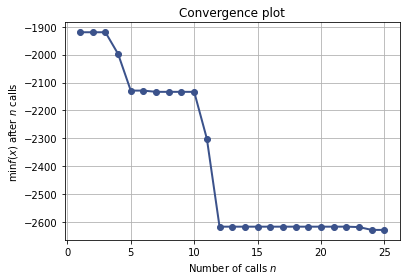

In [11]:
from skopt.plots import plot_convergence

plot_convergence(res_gp)

In [8]:
from skopt import dump, load

In [7]:
dump(res_gp, "1H_opt_RR")

In [9]:
my_res = load("1H_opt_RR")

In [10]:
my_res.x

[0.0015179251497629848,
 2.4553302346427,
 7.154759279489721,
 0.24518881446377816]

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

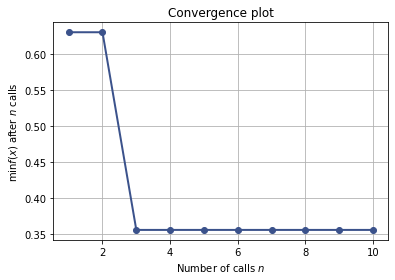

In [18]:
plot_convergence(my_res)